## はじめに
**宙畑 x Ridge-iコラボ企画記事**

衛星画像 x Style transferの検証ノートブックです。

この記事は、[Googleのノートブック](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb)を参考に作成しており、コードの内容はほぼ同一で、適宜説明を加えております。

## データの準備
データを自分のGoogle Driveのフォルダに用意します。
今回は、Google Drive内に、`style_transfer`というフォルダを用意し、その中に`picture`と`satellite`というフォルダを作成し、それぞれ、`VanGohg.jpg`と`Tokyo.jpg`を格納してください。

後は、メニュータブの`ランタイム/全てのセルを実行`を実行することで、自動的にプログラムが実行されます。

なお、ここで使用したサンプルファイルは[こちら](https://drive.google.com/drive/folders/15-mKKMYgoxo4KpqbYSI6MLw5RVRTgYJm?usp=sharing)からダウンロードすることが可能です。

In [ ]:
# Google Driveをマウント
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 画像へのpathを入力
# 今回は、東京の画像とゴッホの絵を加える設定といたします。
content_path = "/content/drive/MyDrive/style_transfer/satellite/Tokyo.jpg"
style_path = "/content/drive/MyDrive/style_transfer/picture/VanGogh.jpg"

## Setup

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

## Quick visualization

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

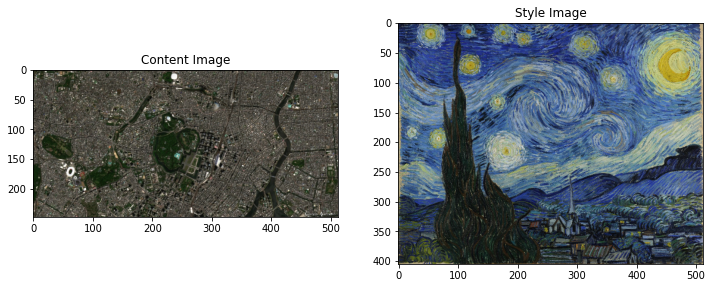

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## とりあえず試してみる
この後、詳しいアルゴリズムの例を掲載しますが、まずは[TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2)で公開されているモデルを用いてクイックに試してどんな絵が取得できそうかを見てみます。

このアルゴリズムは下で詳しく説明している基本的なアルゴリズムから少し発展させたアルゴリズムを使用していますが、試してみるだけであれば、そこまで知る必要はありませんので試してみてください！

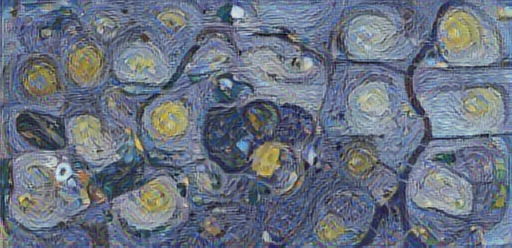

In [ ]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

海や川の部分がかろうじて青くなっておりますが、絵の要素が強く残っていますね！

このモデルでは、パラメータを調整することができませんが、より試してみたい方は以下のコードも試してみてください。

## 詳しく理解したい方、パラメータを調整したい方向け

ここからはより詳しくStyle transferについて学びたい方・パラメータを調整したい方向けです。
モデルは、上記で説明したものと若干異なり、Gatysらによって書かれた[最初の論文](https://arxiv.org/abs/1508.06576)のアルゴリズムを用います。

画像系Deep Learningの場合、最初の数レイヤーは画像のエッジ等低次の概念を学習しており、層が深くなるにつれ、より抽象的な概念（リンゴであれば丸くて赤いものであるという概念）を獲得しています。ImageNet等のデータセットで学習されたネットワークは上記のような概念をどう取得するかについて既に学習しているわけです。

Style transferでは、ImageNetで事前学習されたモデルを使用し、スタイルの元となる画像のスタイルを抽出します。一方で、コンテンツの元となる画像についても、特徴を抽出します。コンテンツの元となる画像については、層が深い部分の特徴量を抽出し、スタイルの元となる画像から抽出された各層の特徴量を用いて画像を1ステップごとに徐々に更新していきます。ステップ数が多くなればなるほど、スタイルの元となる画像の特徴が徐々に反映されていきます。

以下の例では、バックボーン部分にVGG19を用い、ImageNetで学習した重みを用いて、Style Transferを実装していきます。

In [ ]:
# デフォルトのVGG19をダウンロードする
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 6s 0us/step


TensorShape([1, 1000])

In [ ]:
# 分類が正しくできるかテスト
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('cliff', 0.06577978),
 ('walking_stick', 0.05063388),
 ('slug', 0.04507284),
 ('stone_wall', 0.03992157),
 ('cicada', 0.0363249)]

In [ ]:
# VGG19の構造を詳しく可視化
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# "Style"と"Content"をより深く学習しているであろう層を抽出する
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## モデルを構築する

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  661.84894
  mean:  22.843494

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  2801.1147
  mean:  140.22478

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7235.2324
  mean:  135.73282

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16587.87
  mean:  526.55334

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3662.701
  mean:  45.076538



## Styleの計算を行う

CNNでは、層が深くなればなるほどその絵の高次の特徴を学ぶことを上記で示しました。Style transferでは、各層の特徴を効率よく生成するために、GRAM行列を導入しています。

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$


In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.060246296
    max:  17889.77
    mean:  503.64157

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  216599.81
    mean:  19024.316

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  400564.3
    mean:  13794.738

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4163609.5
    mean:  208003.8

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  65304.754
    mean:  1230.08

Contents:
   block5_conv2
    shape:  (1, 15, 32, 512)
    min:  0.0
    max:  1317.7617
    mean:  12.957392


## 勾配降下法を適用する

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
# optimizerにAdamを使用する
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## StyleとContentを調整するパラメータを設定

- `style_weight`の数字を大きくすると、より絵のような質感が増します
- `content_weight`の数字を大きくすると、より画像の質感を保存します


In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## 学習の1stepを定義

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

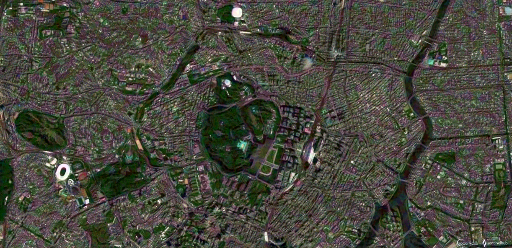

In [ ]:
# 3回トレーニングステップを回してみます
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

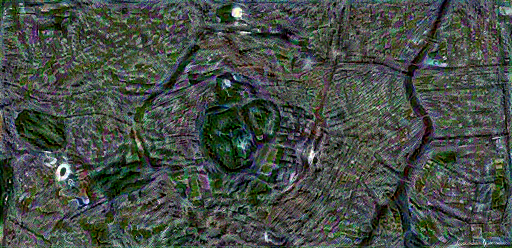

Train step: 20
Total time: 4.1


In [ ]:
# ここでは20回ステップを回してみます

import time
start = time.time()

epochs = 20
steps_per_epoch = 1

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

# 油絵のように画風変換するコード

参考：https://jiupinjia.github.io/neuralpainter/


In [ ]:
!git clone https://github.com/jiupinjia/stylized-neural-painting

Cloning into 'stylized-neural-painting'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 198 (delta 29), reused 26 (delta 10), pack-reused 143
Receiving objects: 100% (198/198), 3.63 MiB | 17.78 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
cd stylized-neural-painting

/content/stylized-neural-painting


In [ ]:
import argparse

import torch
torch.cuda.current_device()
import torch.optim as optim

from painter import *
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# settings
parser = argparse.ArgumentParser(description='STYLIZED NEURAL PAINTING')
args = parser.parse_args(args=[])
args.img_path = content_path # path to input photodri
args.renderer = 'oilpaintbrush' 
args.canvas_color = 'black' # [black, white]
args.canvas_size = 1024 # size of the canvas for stroke rendering'
args.keep_aspect_ratio = True # whether to keep input aspect ratio when saving outputs
args.max_m_strokes = 1000 # max number of strokes
args.max_divide = 10 # divide an image up-to max_divide x max_divide patches
args.beta_L1 = 1.0 # weight for L1 loss
args.with_ot_loss = False # set True for imporving the convergence by using optimal transportation loss, but will slow-down the speed
args.beta_ot = 0.1 # weight for optimal transportation loss
args.net_G = 'zou-fusion-net' # renderer architecture
args.renderer_checkpoint_dir = './checkpoints_G_oilpaintbrush' # dir to load the pretrained neu-renderer
args.lr = 0.005 # learning rate for stroke searching
args.output_dir = './output' # dir to save painting results
args.disable_preview = True # disable cv2.imshow, for running remotely without x-display

事前学習された重みデータのダウンロード

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
# download and unzip...
file_id = '1sqWhgBKqaBJggl2A8sD1bLSq2_B1ScMG'
destination = './checkpoints_G_oilpaintbrush.zip'
download_file_from_google_drive(file_id, destination)

In [ ]:
!unzip checkpoints_G_oilpaintbrush.zip

Archive:  checkpoints_G_oilpaintbrush.zip
   creating: checkpoints_G_oilpaintbrush/
  inflating: checkpoints_G_oilpaintbrush/last_ckpt.pt  


In [ ]:
def optimize_x(pt):

    pt._load_checkpoint()
    pt.net_G.eval()

    print('begin drawing...')

    PARAMS = np.zeros([1, 0, pt.rderr.d], np.float32)

    if pt.rderr.canvas_color == 'white':
        CANVAS_tmp = torch.ones([1, 3, 128, 128]).to(device)
    else:
        CANVAS_tmp = torch.zeros([1, 3, 128, 128]).to(device)

    for pt.m_grid in range(1, pt.max_divide + 1):

        pt.img_batch = utils.img2patches(pt.img_, pt.m_grid, pt.net_G.out_size).to(device)
        pt.G_final_pred_canvas = CANVAS_tmp

        pt.initialize_params()
        pt.x_ctt.requires_grad = True
        pt.x_color.requires_grad = True
        pt.x_alpha.requires_grad = True
        utils.set_requires_grad(pt.net_G, False)

        pt.optimizer_x = optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha], lr=pt.lr, centered=True)

        pt.step_id = 0
        for pt.anchor_id in range(0, pt.m_strokes_per_block):
            pt.stroke_sampler(pt.anchor_id)
            iters_per_stroke = int(500 / pt.m_strokes_per_block)
            for i in range(iters_per_stroke):
                pt.G_pred_canvas = CANVAS_tmp

                # update x
                pt.optimizer_x.zero_grad()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt._forward_pass()
                pt._drawing_step_states()
                pt._backward_x()

                pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                pt.optimizer_x.step()
                pt.step_id += 1

        v = pt._normalize_strokes(pt.x)
        v = pt._shuffle_strokes_and_reshape(v)
        PARAMS = np.concatenate([PARAMS, v], axis=1)
        CANVAS_tmp = pt._render(PARAMS, save_jpgs=False, save_video=False)
        CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size).to(device)

    pt._save_stroke_params(PARAMS)
    final_rendered_image = pt._render(PARAMS, save_jpgs=False, save_video=True)

    return final_rendered_image

In [ ]:
pt = ProgressivePainter(args=args)
final_rendered_image = optimize_x(pt)
# 処理に25分弱かかります

ストリーミング出力は最後の 5000 行に切り捨てられました。
iteration step 12, G_loss: 0.24540, step_acc: 11.18289, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 13, G_loss: 0.24353, step_acc: 11.23161, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 14, G_loss: 0.24139, step_acc: 11.26947, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 15, G_loss: 0.23962, step_acc: 11.32065, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 16, G_loss: 0.23731, step_acc: 11.39614, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 17, G_loss: 0.23385, step_acc: 11.47471, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 18, G_loss: 0.23040, step_acc: 11.56452, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 19, G_loss: 0.22712, step_acc: 11.62414, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 20, G_loss: 0.22491, step_acc: 11.68366, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 21, G_loss: 0.22241, step_acc: 11.73357, grid_scale: 1 / 10, strokes: 1 / 2
iteration step 22, G_loss: 0.22060, step_acc: 11.78165, gr

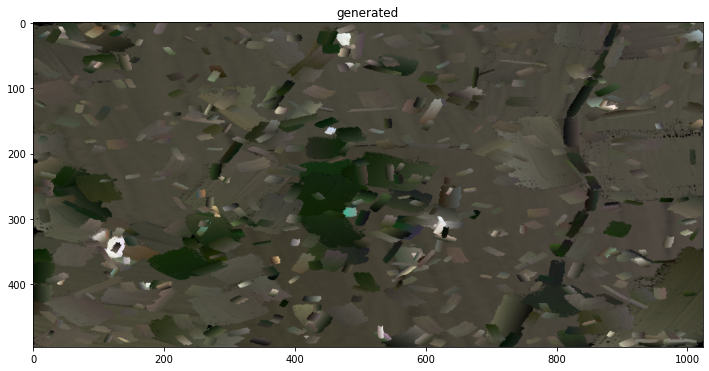

In [ ]:
plt.imshow(final_rendered_image), plt.title('generated')
plt.show()

In [ ]:
cd /content/

/content


In [ ]:
import cv2
im_rgb = cv2.cvtColor(final_rendered_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('output.png', im_rgb*255)

True

※ムービーは`stylezed-neural-painting/output`の中に`.mp4`形式で保存されています